In [3]:
import pandas as pd
import numpy as np

def categorize_target(change):
    if change < -0.05:
        return '-5pct'
    elif -0.05 <= change < -0.02:
        return '-2pct'
    elif -0.02 <= change <= 0.02:
        return '0pct'
    elif 0.02 < change <= 0.05:
        return '+2pct'
    elif change > 0.05:
        return '+5pct'
    else:
        return None


# Original data are in data folder
df = pd.read_csv(
    'data/eDO_data_M1.csv',
    header=None,
    names=['ts', 'open', 'high', 'low', 'close', 'volume'],
    parse_dates=['ts',],
    index_col='ts',
)

print('Full dataset size:         ', len(df))
df = df.drop_duplicates() # Should be safe
print('No duplicates dataset size:', len(df))

Full dataset size:          1541132
No duplicates dataset size: 1541040


# Data cleaning & quality checks

## 1. There is mistake in data: summer time change (27.10) duplicates datapoints.
- Without knowing which data are from which hour (either 0:00 or 1:00) its impossible to do anything meaningfull with those observations.
- Fix: Based on the plots of close value, we can assume that first datapoint with the same timestamp is from 0:00 and second from 1:00
- This is reasonable because second datapoint from 0:00 directly connects to last datpoint from 1:59

Found duplicates 120


<Axes: xlabel='ts'>

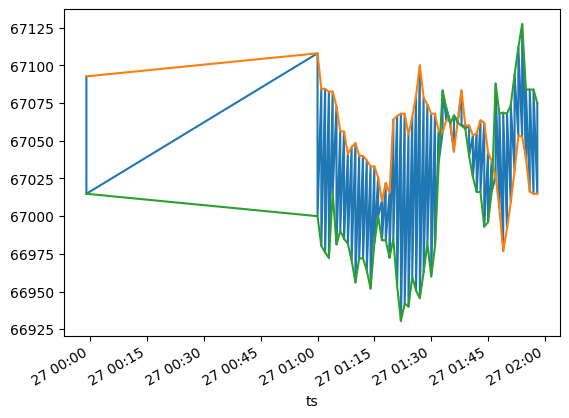

In [2]:
duplicates = df.index.duplicated(keep=False)
print('Found duplicates', sum(duplicates))

df[duplicates]['close'].plot() # Notice the weird oscilation - there are two timeseries interlined.
df[duplicates].groupby('ts')['close'].first().plot()
df[duplicates].groupby('ts')['close'].last().plot()

In [3]:
# Fix Summer time duplicates

# 0:00 - All wrong except first value
df_first = df[duplicates].groupby('ts').first()
index = df_first.index.values
index[1:] = index[1:] - pd.Timedelta('1hour')
df_first.index = index

# 1:00 - All Correct except first value
df_last = df[duplicates].groupby('ts').last()
index = df_last.index.values
index[:1] = index[:1] + pd.Timedelta('1hour')
df_last.index = index

df = pd.concat([df[~duplicates], df_first, df_last])
duplicates = df.index.duplicated(keep=False)
assert duplicates.sum() == 0

## 2. There are missing data for 4540 minutes
- Inconsecutive time stamps are problematic for aggregation and time series analysis - data is not proper timeseries.
- We can either ignore/delete those values and work with incomplete timeseries, or fill it.
- I decide to ffill the values and add categorical variable to indicate that it was filled. Having variable about data outage can be also important for a model.

In [4]:
print('Number of jumps is timestamps: ', len(df[~(df.index.to_series().diff() == pd.Timedelta('1min'))]))

df = df.resample('1min').asfreq()
df.index.name = 'ts'

is_missing = df.isnull().any(axis=1)
print('number of missing minutes:     ', sum(is_missing))

# Example: Large several hours of outage
display(df.loc['2023-03-24 11:26:00': '2023-03-24 14:02:00'])

# Example: Minor few missing minutes
display(df.loc['2024-11-20 07:18:00': '2024-11-20 07:25:00'])

# Fix: front fill and indicator variable
df = df.ffill()
df['filled'] = is_missing


df.to_csv('data/data-min-clean.csv')

Number of jumps is timestamps:  154
number of missing minutes:      4590


,open,high,low,close,volume
ts,,,,,
2023-03-24 11:26:00,28060.41,28068.82,28058.67,28068.79,24.35528
2023-03-24 11:27:00,28068.79,28080.00,28068.79,28080.00,15.66899
2023-03-24 11:28:00,28080.00,28080.00,28080.00,28080.00,0.00000
2023-03-24 11:29:00,NaN,NaN,NaN,NaN,NaN
2023-03-24 11:30:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-03-24 13:58:00,NaN,NaN,NaN,NaN,NaN
2023-03-24 13:59:00,NaN,NaN,NaN,NaN,NaN
2023-03-24 14:00:00,28079.99,28079.99,27901.06,27925.59,293.30587


,open,high,low,close,volume
ts,,,,,
2024-11-20 07:18:00,92564.10,92625.18,92564.10,92625.17,16.26450
2024-11-20 07:19:00,92625.17,92785.29,92625.17,92757.58,95.18182
2024-11-20 07:20:00,NaN,NaN,NaN,NaN,NaN
2024-11-20 07:21:00,NaN,NaN,NaN,NaN,NaN
2024-11-20 07:22:00,92727.22,92760.00,92660.00,92724.00,37.60972
2024-11-20 07:23:00,92723.99,92723.99,92640.00,92646.92,15.55642
2024-11-20 07:24:00,92646.92,92770.90,92646.92,92710.93,50.65173
2024-11-20 07:25:00,92710.93,92710.94,92636.34,92636.34,20.15722


# Hourly dataset
- Here I create set of basic features from minute data

In [11]:
df = pd.read_csv(
    'data/data-min-clean.csv',
    parse_dates=['ts',],
    index_col='ts',
).sort_index()



# Aggregate to hourly data
df['logret'] = np.log(df['close'] / df['close'].shift(1))
df['volume_pct_change'] = df['volume'].pct_change().fillna(0)
df_h1 = df.resample('1h').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
})

# Get intra-hour data that would be otherwise lost
df_h1['logret_intra_vol'] = df['logret'].resample('1h').std()
df_h1['logret_intra_skew'] = df['logret'].resample('1h').apply(pd.Series.skew)
df_h1['logret_intra_kurt'] = df['logret'].resample('1h').apply(pd.Series.kurt)


# Get splits & target
df_h1 = df_h1.loc[: '2024-12-01 09:00:00'].copy() # overlap to 12/2024 to calculate target returns
df_h1.loc['2022-01-01 00:00:00': '2024-10-01 0:00:00', 'split'] = 'train'
df_h1.loc['2024-10-01 00:00:00': '2024-11-01 0:00:00', 'split'] = 'val'
df_h1.loc['2024-11-01 00:00:00': '2024-12-01 0:00:00', 'split'] = 'test'

df_h1['target_ret'] = (df_h1['close'].shift(-10) - df_h1['close']) / df_h1['close']
df_h1['target'] = df_h1['target_ret'].apply(categorize_target)

df_h1 = df_h1.dropna() # Drops the 10 observations overlapping to 12/2024
df_h1.to_csv('data/data-hour-clean.csv')

# Explore the data
- Returns are centered around 0, with heavy tails. Most common category is 0pct

In [4]:
df_h1 = pd.read_csv(
    'data/data-hour-clean.csv',
    parse_dates=['ts',],
    index_col='ts',
).sort_index()


df_h1['target'].value_counts(normalize=True) * 100

target
0pct     82.390454
+2pct     8.059468
-2pct     6.983568
+5pct     1.338028
-5pct     1.228482
Name: proportion, dtype: float64

In [5]:
df_h1['target_ret'].describe()

count    25560.000000
mean         0.000441
std          0.017884
min         -0.127962
25%         -0.006705
50%          0.000070
75%          0.007329
max          0.135715
Name: target_ret, dtype: float64

<Axes: >

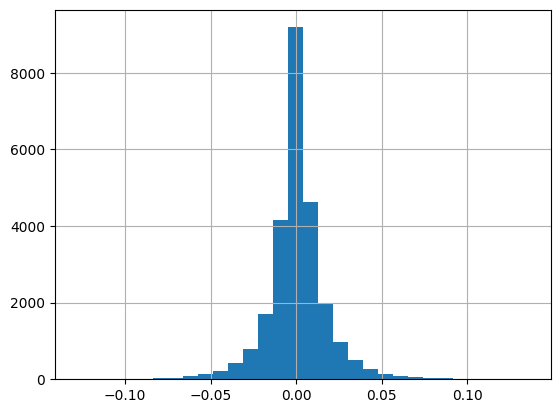

In [7]:
df_h1['target_ret'].hist(bins=30)

<Axes: xlabel='ts'>

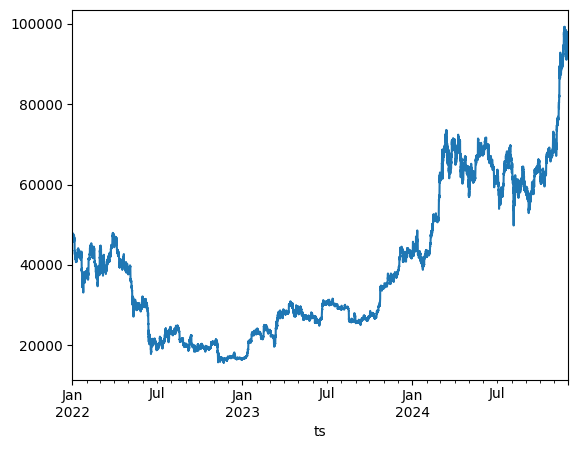

In [15]:
df_h1['close'].plot()